In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pylab import *
from scipy import stats
from scipy import optimize
import arviz as az
import h5py
import pandas as pd
import seaborn as sns

import ringdown

sns.set_context('notebook')
sns.set_palette('colorblind')

In [3]:
!openssl md5 H-H1_GWOSC_16KHZ_R1-1242442952-32.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1242442952-32.hdf5

MD5(H-H1_GWOSC_16KHZ_R1-1242442952-32.hdf5)= b17716d90416df6670a10211f7650799
MD5(L-L1_GWOSC_16KHZ_R1-1242442952-32.hdf5)= 6616c76a6797da795ad347e1e5b2b489


In [4]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_16KHZ_R1-1242442952-32.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_16KHZ_R1-1242442952-32.hdf5', 'L1')

In [5]:
# M_est = 340
# chi_est=0.9

T = 0.2
srate = 4096

In [117]:
def set_data(M_est,chi_est):
    fit1 = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 3, 3, 0)])
    fit1.add_data(h_raw_strain)
    fit1.add_data(l_raw_strain)
    t_unit=M_est*2950./2/299792458
    ts_ins=0.125
    fit1.set_target(1242442967.445-2*ts_ins, ra=3.29, dec=0.510509, psi=0.82, duration=T+2*ts_ins)
    fit1.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)
    fit1.filter_data(chi_est,M_est,2,2,0)
#     fit1.filter_data(chi_est,M_est,3,3,0)
    fit1.set_target(1242442967.445+0.05, ra=3.29, dec=0.510509, psi=0.82, duration=T)
    fit1.condition_data(ds=1, flow=20)
    fit1.compute_acfs()
    wd1 = fit1.analysis_data
    return fit1,wd1

In [118]:
# plot(wd1['H1'], label='H1')
# # plot(wd['L1'], label='L1')
# legend(loc='best');
# xlabel(r'Sample Number');
# ylabel(r'Whitened Analysis Data');

In [119]:
def compute_likelihood(fit1,wd1):
    Ls=fit1.obtain_L()
    strains=np.array([s.values for s in wd1.values()])
    times=np.array([array(d.time) for d in wd1.values()])
    likelihood=0
    for i in range(len(strains)):
        norm=np.sqrt(np.sum(abs(np.dot(np.linalg.inv(Ls[i]),Ls[i])-np.identity(len(Ls[i])))**2))
        if abs(norm)>1e-8:
            raise ValueError("inverse of L is not correct")
        whitened=np.dot(np.linalg.inv(Ls[i]),strains[i])
        likelihood-=0.5*np.dot(whitened,whitened)
    return likelihood

In [120]:
def total(M_est,chi_est):
    fit1,wd1=set_data(M_est,chi_est)
    likelihood=compute_likelihood(fit1,wd1)
    return likelihood

In [121]:
chispace=np.arange(0.5,0.95,0.1)
massspace=np.arange(240,360,10)

In [122]:
finalfinal=[]
for j in chispace:
    final=[]
    for i in massspace:
        final.append(total(i,j))
    finalfinal.append(final)
finalfinal=np.array(finalfinal)

In [123]:
X, Y = np.meshgrid(massspace,chispace)

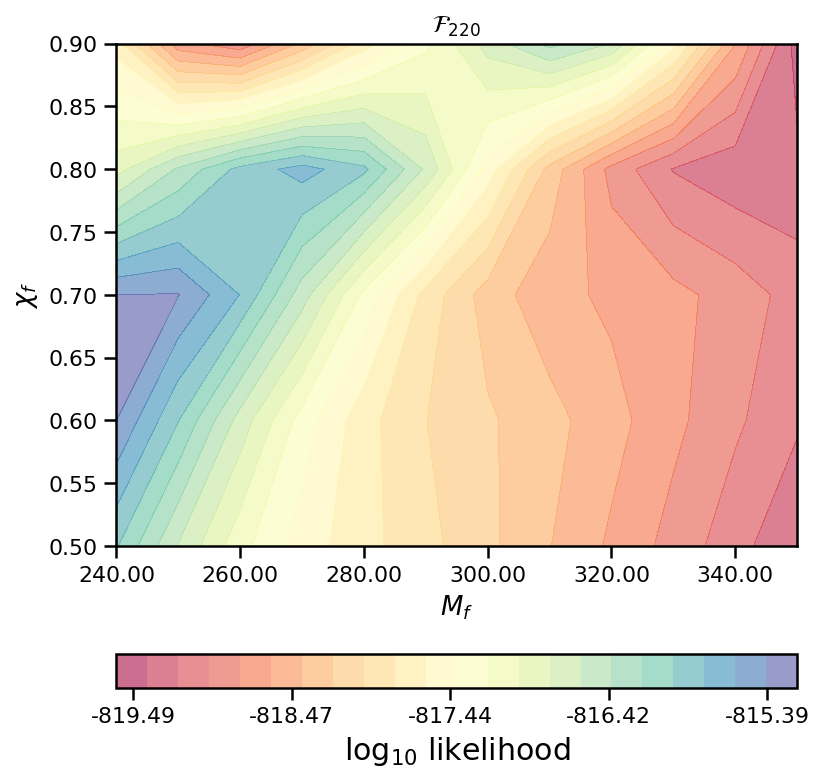

In [124]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours=ax.contourf(X, Y, finalfinal,20, cmap='Spectral', origin='lower',alpha=0.6,linestyles='--')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax.scatter(x=68.5,y=0.69,s=255,marker='+',c='g',linewidths=4,label='IMR')
cbar=fig.colorbar(contours,orientation="horizontal", pad=0.15,format='%3.2f')

cbar.set_label(r'$\log_{10}$ likelihood',fontsize=15)
cbar.set_ticks(np.linspace(np.min(finalfinal),np.max(finalfinal),5))
pl.xlabel(r'$M_f$',fontsize=13)
pl.ylabel(r'$\chi_f$',fontsize=13)

contoursnew=ax.contour(contours,levels=[-158,-152],linewidths=2,linestyles='--',colors='k')

counterlabel=ax.clabel(contoursnew,contoursnew.levels
                       , inline=True, fontsize=12,fmt='%2.1f'
                       ,rightside_up=False,use_clabeltext=True,colors='k')


for l in counterlabel:
    l.set_rotation(0)

ax.set_title(r'$\mathcal{F}_{220}$')
# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{330}$')
pl.savefig('22.pdf')